# Find Pyramids
The Python code is available at: https://github.com/AEljarrat/pyramids email: aeljarrat@physik.hu-berlin.de
<br> There are some example images and calculation results in the `./images` and `./results` folders.

<b>Saving NPY, NPZ and images</b><br>
When executing online notebooks, download the NPY and NPZ files generated after the calculations -> recover the results <br> 
While the figures are interactive, they can be saved to disk using the save button below each panel. 

<b>PyramidTool() Function</b> --> Automatic/Manual finding of maxima:
1. Find the foreground, find ALL local maxima
2. Reduce this to single isolated indices, Basin fill using watershed segmentation --> color pyramids. 
3. Manual correction: Left click button: Add point    Right click button: Remove points  (Live update!)

<b>Measure_pyramids () Function </b> --> ray-traces the pyramid vertices at a given angle --> pyramid edge length and height. The steps:
1. The center of each pyramid is re-calculated to improve the results.
2. An angle is provided by the user (e.g. 45 deg).
3. From each pyramid center 4 rays are traced using the provided angle.
4. A pyramid vertex is found where each ray touched the pyramid boundary.

FileChooser(path='C:\Users\ogr\Nextcloud\Python\Small Pyramids finder', filename='', title='<h2>Find Pyramid T…

<IPython.core.display.Javascript object>


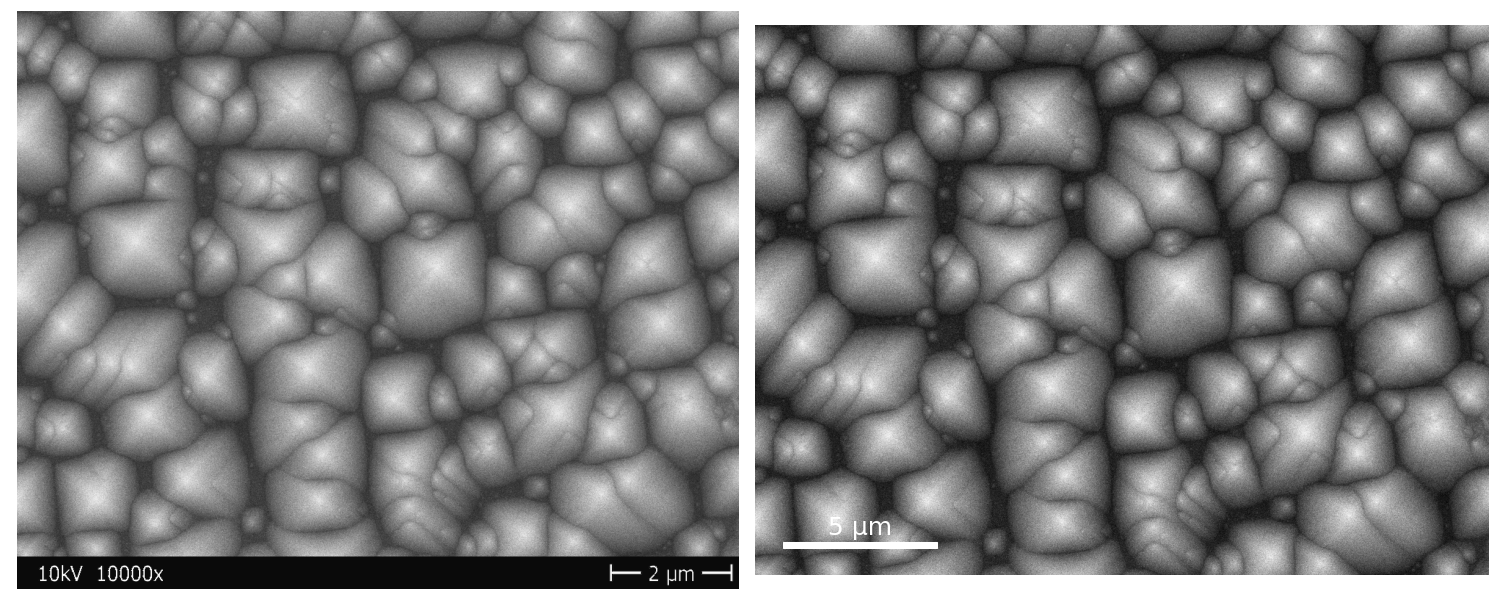

In [26]:
import ipywidgets as widgets
import os, time, datetime
import matplotlib.pyplot as plt
%matplotlib nbagg
from pyramids.source_GUI import Image, PyramidTool
from IPython.core.display import display, HTML
from tkinter import Tk, filedialog
display(HTML("<style>.container { width:95% !important; }</style>"))

from ipyfilechooser import FileChooser

def default_5000(b):
    text_X0.value = str(780)
    text_X1.value = str(990)
    text_scalebarsize.value = str(5)
    calculate_scale(b)
    
def default_10000(b):
    text_X0.value = str(820)
    text_X1.value = str(990)
    text_scalebarsize.value = str(2)
    #5000x: 780, 990, 5µm  -  10000x: 820, 990, 2µm
    calculate_scale(b)

#def select_file(b):
    #global fc
    #root = Tk()
    #root.withdraw()                                        # Hide the main window.
    #root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    #b.files = filedialog.askopenfilename(multiple=False)    # List of selected files will be set button's file attribute.

    #if b.files == "": return
    #image_name = b.files

def show_scale_image(b):
    image_name = fc.selected
    
    pixel_size = int(text_scalebarsize.value) / (int(text_X1.value) - int(text_X0.value))
    pixel_size = round(pixel_size, 6)
    text_pixelscale.value = str(pixel_size)
    
    image_selected = Image(image_name, pixel_size=pixel_size, autocrop=False) # generate image object
    f2, axs2 = image_selected.show2(scalebar_size=int(text_scalebarsize.value)) #plot original image and image with scale
    
    
def calculate_scale(b):
    pixel_size = int(text_scalebarsize.value) / (int(text_X1.value) - int(text_X0.value))
    pixel_size = round(pixel_size, 6)
    text_pixelscale.value = str(pixel_size)
    
    
def clear_figure(b):
    fig = plt.gcf()
    fig.set_size_inches(0.001, 0.001)
    plt.clf()
    plt.close()

def select_file2(b):
    global pt
    global image_selected
    global image_name
    global filename_image
    global pixel_size
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=False)    # List of selected files will be set button's file attribute.                                       
    if b.files == "": return
    image_name = b.files
    filename_image = os.path.basename(image_name)[:-4]
    
    pixel_size = int(text_scalebarsize.value) / (int(text_X1.value) - int(text_X0.value))
    bool_small_pyramids = CheckboxSmallPyramids.value 
    
    median_filter = intslider_medianfilter.value
    image_selected = Image(image_name, pixel_size=pixel_size, bool_small_pyramids = bool_small_pyramids)
    image_selected.median_filter(size=median_filter)
    
    threshold_factor = floatslider_threshold.value
    initial_peaks = intslider_maxima.value
    
    pt = PyramidTool(image_selected, filename_image, bool_small_pyramids, threshold_factor, initial_peaks,  dpi=60, figsize=(20, 8.4)) # find maxima
    button3.disabled = False
    button4.disabled = False
    button_measure.disabled = False
    button_reload.disabled = False

def reload(b):
    #clear_figure(b)
    global pt
    bool_small_pyramids = CheckboxSmallPyramids.value 
    median_filter = intslider_medianfilter.value
    image_selected = Image(image_name, pixel_size=pixel_size, bool_small_pyramids = bool_small_pyramids)
    image_selected.median_filter(size=median_filter)
    threshold_factor = floatslider_threshold.value
    initial_peaks = intslider_maxima.value
    
    pt = PyramidTool(image_selected, filename_image, bool_small_pyramids, threshold_factor, initial_peaks,  dpi=60, figsize=(20, 8.4)) # find maxima
    plt.show()
    
def save_coordinates(b): 
    global pt
    pt.save_coordinates('results/' + filename_image + ' - pyramid coords.npy') # Save NPY file

def load_coordinates(b):
    global pt
    root = Tk()
    root.withdraw()                                        # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=False)    # List of selected files will be set button's file attribute.   
    pt.load_coordinates(b.files) # Load NPY file with previous coordinates. 
    
    
def measure_pyramids(b):
    global pt
    pyramidangle = int(text_pyramidangle.value)
    pt.measure_pyramids(pyramid_angle=pyramidangle) 
    pt.save_pyramid_measurements('results/' + filename_image + ' - pyramid measurements.npz') # Save NPZ file
    button_plotcontrol.disabled = False
    button_plotheight.disabled = False
    
    
def plot_controlcharts(b):  # plot Vertex Size + # vertex orientation + vertex coordinates
    pixel_scale = float(text_pixelscale.value)
    sname = 'results/' + filename_image + ' - pyramid measurements.npz'
    vertices = np.load(sname)['vertices']
    moduli = np.sqrt(np.sum(vertices**2, -1)) * pixel_scale
    angles = np.arctan2(vertices[..., 1], vertices[..., 0])
    max_indices = np.argmax(moduli, -1)
    moduli_max = np.array([moduli[io, idx] for io, idx in enumerate(max_indices)])
    angles_max = np.array([angles[io, idx] for io, idx in enumerate(max_indices)])
    angles_max_deg = np.rad2deg(angles_max+np.pi)
    angles_deg = np.rad2deg(angles+np.pi)
    v_plt = vertices.reshape(-1, 2)
    
    figsize = plt.figaspect(1/2.5)
    f, axs = plt.subplots(1, 3, dpi=90, figsize=figsize) 
    
    ax = axs[0]
    ax.hist(moduli_max, bins=25, range=(0., 4.5), label='Max vertices')
    ax.set_xlabel('Vertex size [µm]')
    ax.set_ylabel('Counts [pyramid]')
    
    ax = axs[1]
    ax.hist(angles_deg.reshape(-1), bins=50, range=(0., 360.))
    ax.set_xlabel('Vertex orientation [deg]')
    
    ax = axs[2]
    ax.scatter(v_plt[:, 1]*pixel_scale, v_plt[:, 0]*pixel_scale, s=5, c='b', marker='+')
    ax.set_ylim(-3., +3.)
    ax.set_xlim(-3., +3.)
    ax.grid('on')
    ax.set_aspect('equal')
    ax.set_title('Vertex coordinates [µm]')
    

def plot_heightchart(b): 
    pixel_scale = float(text_pixelscale.value)
    sname = 'results/' + filename_image + ' - pyramid measurements.npz'
    vertices = np.load(sname)['vertices']
    moduli = np.sqrt(np.sum(vertices**2, -1)) * pixel_scale
    height = np.tan(np.deg2rad(angle_sideedge)) * moduli
    max_indices = np.argmax(moduli, -1)
    height_max = np.array([height[io, idx] for io, idx in enumerate(max_indices)])
    
    angles = np.arctan2(vertices[..., 1], vertices[..., 0])
    moduli_max = np.array([moduli[io, idx] for io, idx in enumerate(max_indices)])
    angles_max = np.array([angles[io, idx] for io, idx in enumerate(max_indices)])
    angles_max_deg = np.rad2deg(angles_max+np.pi)
    #height_max2 = np.tan(np.deg2rad(angle_sideedge))*moduli_max

    f = plt.figure(dpi=72, figsize=(9,4))
    #f.suptitle(filename_image, fontsize=16)
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    image_selected.show(fig=f, ax=ax)
    
    ax = ax2
    Rbins = (int(text_Xstart.value), int(text_Xend.value))
    ax.hist(height_max, bins=int(text_binning.value), range=Rbins, label='Max vertices', alpha=0.5, edgecolor = 'blue')
    ax.set_title(filename_image)
    ax.set_xlabel('Pyramid height [µm]')
    ax.set_ylabel('Counts [pyramids]')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    plt.tight_layout()
    f.savefig('results/' + filename_image + ' - heights.png')
    
    np.savetxt(
        fname = 'results/' + filename_image + ' - pyramid measurements.csv', 
        X = np.stack([moduli_max, angles_max_deg, height_max], axis=1),
        fmt = '%.5f',
        delimiter = ';',
        header=filename_image + ' - modulus [um];' + filename_image + ' - orientation [deg];' + filename_image + ' - height [um]; Pixel size: ' + str(pixel_scale), 
        #comments='Pixel Size = {1:.5f} um / pixel \n'.format(pixel_scale)
        )
    pt.axes[0].figure.savefig('results/' + filename_image + ' - images.jpg', dpi=120)
    

html = "<h1 style='font-size:30px'> Find Pyramids Tool </h1>"
Headertext = widgets.HTML(value=html)

HeaderLabel_line= widgets.Label(value = "--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

HeaderLabel= widgets.Label(value = 'Find SCALE: Open TIF image, find left&right pixel of the scale, calculate the µm/pixel. Defaults: ', 
                          layout=widgets.Layout(padding="0px 0px 10px 4px"))

widget_width = "1000px"
#padding = "4px 4px 4px 4px"  # upper, right, bottom, left

button5000 = widgets.Button(value=None,description="5000x", layout=widgets.Layout(width='80px'))
button5000.on_click(default_5000)

button10000 = widgets.Button(value=None,description="10000x", layout=widgets.Layout(width='80px'))
button10000.on_click(default_10000)

button1a = widgets.Button(value=None,description="Show scale image",button_style="primary")
button1a.on_click(show_scale_image)

text_X0 = widgets.Text(value="",description="Left and right pixel of the scale bar:",style={"description_width": "initial"}, 
                    layout=widgets.Layout(padding="0px 0px 4px 30px"))
text_X1 = widgets.Text(value="",description="-",style={"description_width": "initial"}, 
                    layout=widgets.Layout(width ="70px",padding="0px 0px 4px 0px"))

text_scalebarsize = widgets.Text(value="",description="Scalebar_size (µm):",style={"description_width": "initial"}, 
                    layout=widgets.Layout(width="200px", padding="0px 0px 4px 30px"))

button1b = widgets.Button(value=None,description="Re-calculate Scale", layout=widgets.Layout(padding="0px 0px 4px 10px"))
button1b.on_click(calculate_scale)

#buttonshowscaleimage = widgets.Button(value=None,description="show scale images", layout=widgets.Layout(padding="0px 0px 4px 10px"))
#buttonshowscaleimage.on_click(show_scale_image)

text_pixelscale = widgets.Text(value="",description="Pixel scale (µm/pixel):",style={"description_width": "initial"}, 
                    layout=widgets.Layout(width="250px", padding="0px 0px 4px 30px"))

            
HeaderLabel2= widgets.Label(value = 'Process a SEM image: Open TIF file, then correct the pyramid positions and save the coordinates as NPY file (optional: load a NPY file)')

CheckboxSmallPyramids = widgets.Checkbox(value=False,description='Small pyramid analysis',disabled=False,indent=False)

button2 = widgets.Button(value=None,description="Load image",button_style="primary")
button2.on_click(select_file2)

button3 = widgets.Button(value=None,description="Save coord. NPY")
button3.on_click(save_coordinates)
button3.disabled = True

button4 = widgets.Button(value=None,description="Load coord. NPY")
button4.on_click(load_coordinates)
button4.disabled = True


#Settings
Headersettings= widgets.Label(value = 'Try alternative settings and then reload the image (button below)')


floatslider_threshold = widgets.FloatSlider(value=0.9, min=0.8, max=1.1,step=0.02, description='Threshold factor:', 
      style={'description_width': 'initial'}, layout=widgets.Layout(width = "400px", padding="0px 0px 0px 30px"),
      continuous_update=False, orientation='horizontal', readout=True,readout_format='.2f')

intslider_maxima = widgets.IntSlider(value=25, min=2, max=50,step=1, description='Number of initial local maxima :', style={'description_width': 'initial'},
    continuous_update=False, orientation='horizontal', readout=True, 
    layout=widgets.Layout(width ="400px", padding="0px 0px 0px 30px"))

intslider_medianfilter = widgets.IntSlider(value=2, min=1, max=5,step=1, description='Image blur:', 
      style={'description_width': 'initial'},layout=widgets.Layout(width = "400px", padding="0px 0px 0px 30px"),
      continuous_update=False, orientation='horizontal', readout=True)



Headernix= widgets.Label(value = '  ')
HeaderMeasure= widgets.Label(value = 'Highlight the pyramid edges in the image and calculate the pyramid height by using its longest edge.')

button_measure = widgets.Button(value=None,description="Measure Pyramids",button_style="primary")
button_measure.on_click(measure_pyramids)
button_measure.disabled = True

text_pyramidangle = widgets.Text(value="",description="Use a pyramid orientation angle of:",style={"description_width": "initial"}, 
                    layout=widgets.Layout(width="270px", padding="0px 0px 4px 0px"))
text_pyramidangle.value = str(45)

button_plotcontrol = widgets.Button(value=None,description="Plot control charts")
button_plotcontrol.on_click(plot_controlcharts)
button_plotcontrol.disabled = True

button_plotheight = widgets.Button(value=None,description="Height chart & Export",button_style="success")
button_plotheight.on_click(plot_heightchart)
button_plotheight.disabled = True

text_Xstart = widgets.Text(value="",description="with X axis:",style={"description_width": "initial"}, 
                    layout=widgets.Layout(width="110px", padding="0px 0px 4px 0px"))
text_Xstart.value = str(0)

text_Xend = widgets.Text(value="",description="-",style={"description_width": "initial"}, 
                    layout=widgets.Layout(width="50px", padding="0px 0px 4px 0px"))
text_Xend.value = str(5)

text_binning = widgets.Text(value="",description="Binning:",style={"description_width": "initial"}, 
                    layout=widgets.Layout(width="100px", padding="0px 0px 4px 8px"))
text_binning.value = str(25)

label_bla = widgets.Label(value = ' ')

button_hide = widgets.Button(value=None,description="Remove last figure")
button_hide.on_click(clear_figure)


button_reload = widgets.Button(value=None,description="Reload image") #layout=widgets.Layout(width = "auto")
button_reload.on_click(reload)
button_reload.disabled = True

#button_export = widgets.Button(value=None,description="Export data",button_style="success")
#button_export.on_click(export_data)
#button_export.disabled = True

text_X0.value = str(780)
text_X1.value = str(990)
text_scalebarsize.value = str(5)

pixel_size = int(text_scalebarsize.value) / (int(text_X1.value) - int(text_X0.value))
pixel_size = round(pixel_size, 6)
text_pixelscale.value = str(pixel_size)
                   
angle_sideedge = 54.7 #pyramid angle of the side edge 

#html

fc = FileChooser()
fc.title = '<h2>Find Pyramid Tool</h2><h3> Use the File Chooser for a TIF/NPY file</h3>'
display(fc)

toolbar_widget = widgets.VBox()
toolbar_widget.children = [
    HeaderLabel_line,
    widgets.HBox([HeaderLabel, button5000, button10000]),
    widgets.HBox([button1a, text_X0, text_X1, text_scalebarsize]),
    widgets.HBox([button1b, text_pixelscale]),
    HeaderLabel_line,
    HeaderLabel2,
    widgets.HBox([button2,button3,button4,CheckboxSmallPyramids]),
    widgets.HBox([Headersettings, ]),
    widgets.HBox([widgets.VBox([floatslider_threshold, intslider_maxima, intslider_medianfilter],layout=widgets.Layout(width='30%', display='flex',align_items='flex-end')),
                  widgets.VBox([label_bla, label_bla, button_reload], layout=widgets.Layout(width='30%', display='flex',align_items='flex-start'))]),
    widgets.HBox([HeaderMeasure,text_pyramidangle]), 
    widgets.HBox([button_measure, button_plotcontrol,button_plotheight, text_Xstart, text_Xend, text_binning]), 
    #Headernix,
    #widgets.HBox([button_export]),
    HeaderLabel_line,
    widgets.HBox([button_hide])
    ]
toolbar_widget


